## Example notebook for inferring CD8 differentiation trajectories

In [1]:
import os
import pandas as pd
import numpy as np
import scanpy as sc 
import matplotlib.pyplot as plt
import logging
from venn import venn
import sys
sys.path.append('..')
import delve_benchmark

%load_ext autoreload
%autoreload 2

adata_directory = '../data/Zenodo' ## https://zenodo.org/records/10105826
adata = sc.read_h5ad(os.path.join(adata_directory, 'adata_CD8.h5ad'))

### Perform DELVE feature selection

In [2]:
n_selected = 500
k = 10
n_pcs = 50
trial = 0

feature_directory = os.path.join('../data', 'CD8', 'predicted_features_runner')
delve_benchmark.pp.make_directory(feature_directory)

fs = delve_benchmark.tl.fs(adata = adata, fs_method = delve_benchmark.tl.run_delve_fs, fs_method_params = {'num_subsamples': 1000, 'n_pcs': n_pcs, 'n_clusters': 5, 'k': k, 'n_random_state': 10, 'return_modules': True, 'random_state': 93})
delta_mean, modules, delve_genes = fs.select()
##save 
delve_genes.to_csv(os.path.join(feature_directory, f'delve_fs_trial{trial}.csv'))
delve_genes = delve_genes.index[:n_selected]
delta_mean.to_csv(os.path.join(feature_directory, f'delta_mean_trial{trial}.csv'))
modules.to_csv(os.path.join(feature_directory, f'modules_trial{trial}.csv'))

INFO:root:Step 1: identifying dynamic feature modules
INFO:root:estimating feature dynamics
performing subsampling: 100%|██████████| 1/1 [00:08<00:00,  8.25s/it]
clustering features and performing gene-wise permutation testing: 100%|██████████| 10/10 [03:12<00:00, 19.24s/it]
INFO:root:identified 3 dynamic cluster(s)
INFO:root:Step 2: performing feature selection


### Plot dynamic modules

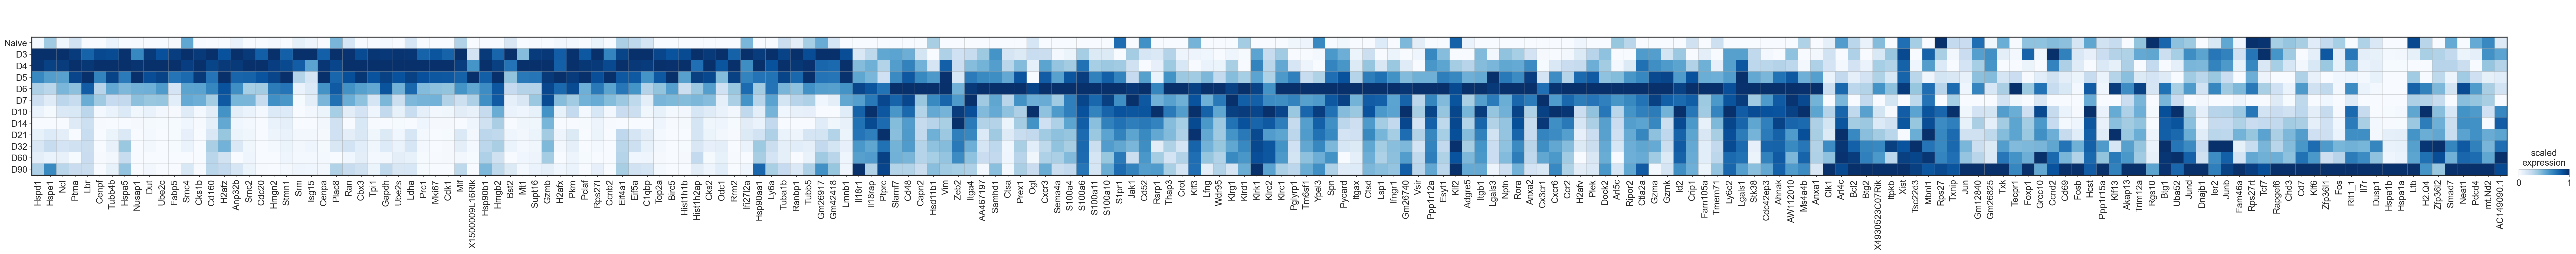

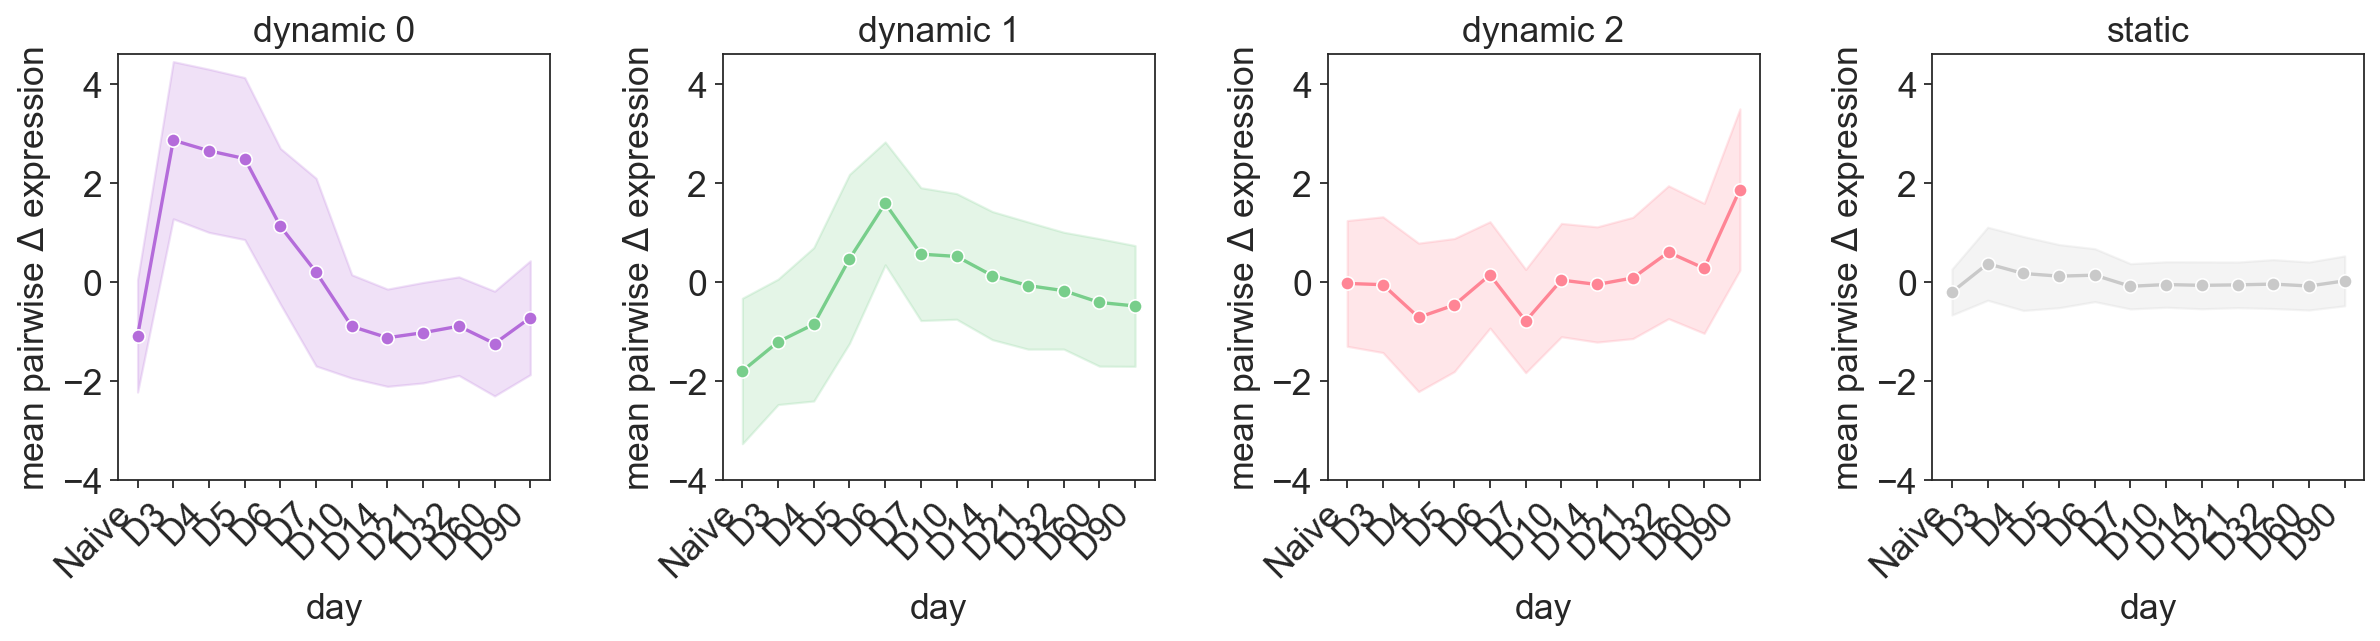

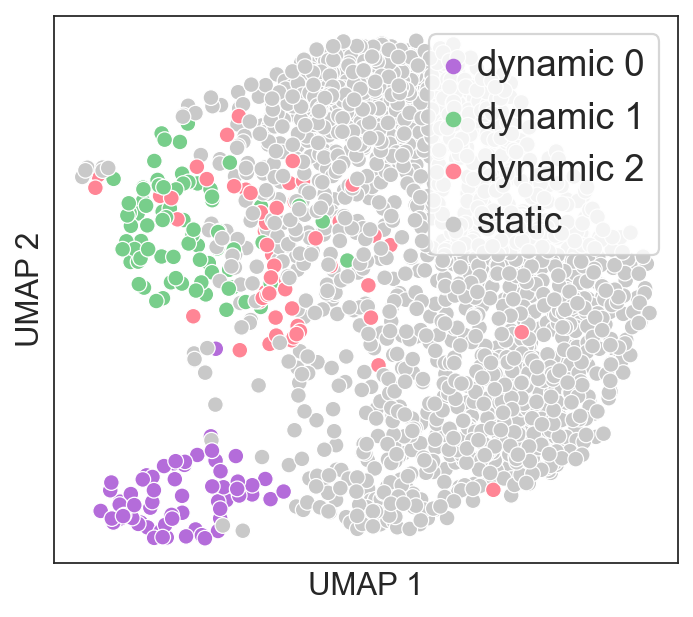

In [3]:
## plot seed dynamics
seed_directory = os.path.join('../figures', 'CD8', 'seed_runner')
delve_benchmark.pl.plot_seed(adata_directory = adata_directory, feature_directory = feature_directory, adata_name = 'adata_CD8', labels_key = 'day', m_order= ['Naive', 'D3', 'D4', 'D5', 'D6','D7', 'D10', 'D14', 'D21', 'D32', 'D60', 'D90'],
                            save_directory = seed_directory, filename_save = 'CD8', trial = trial, ylim = [-4, 4.6], reorder = {'dynamic 0': 'dynamic 0', 'dynamic 1': 'dynamic 2', 'dynamic 2': 'dynamic 1', 'static':'static'})

### Assess the significance of dynamically expressed genes within DELVE modules using the [STRING](https://string-db.org/) database

#### Plot DELVE dynamic module association networks

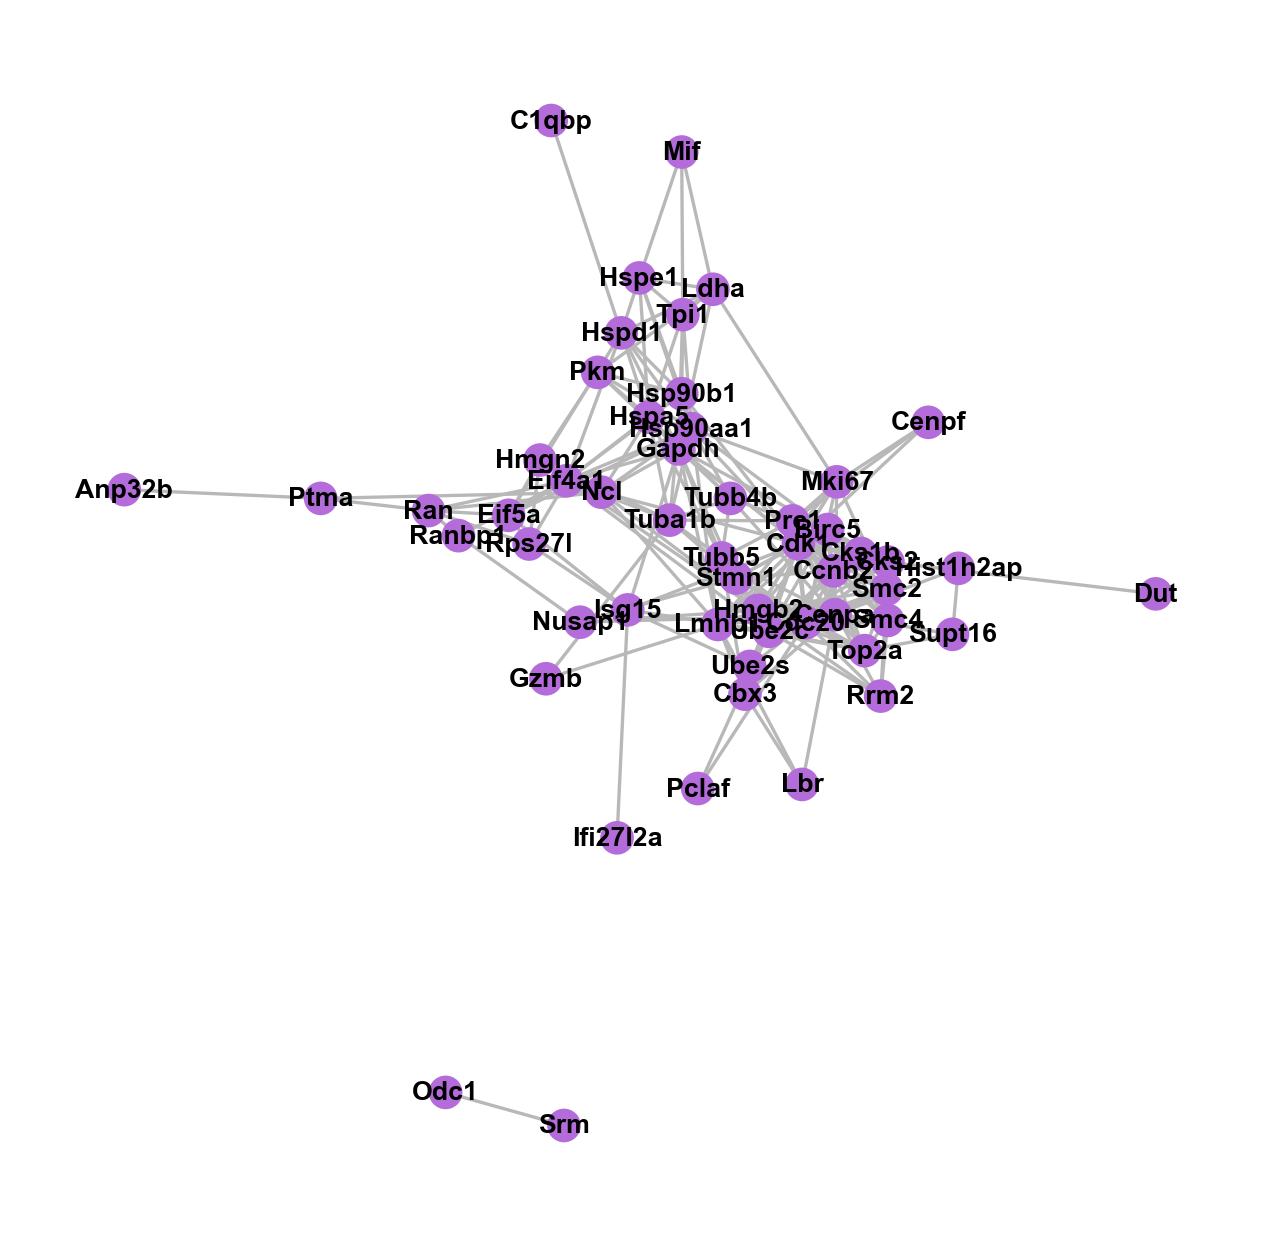

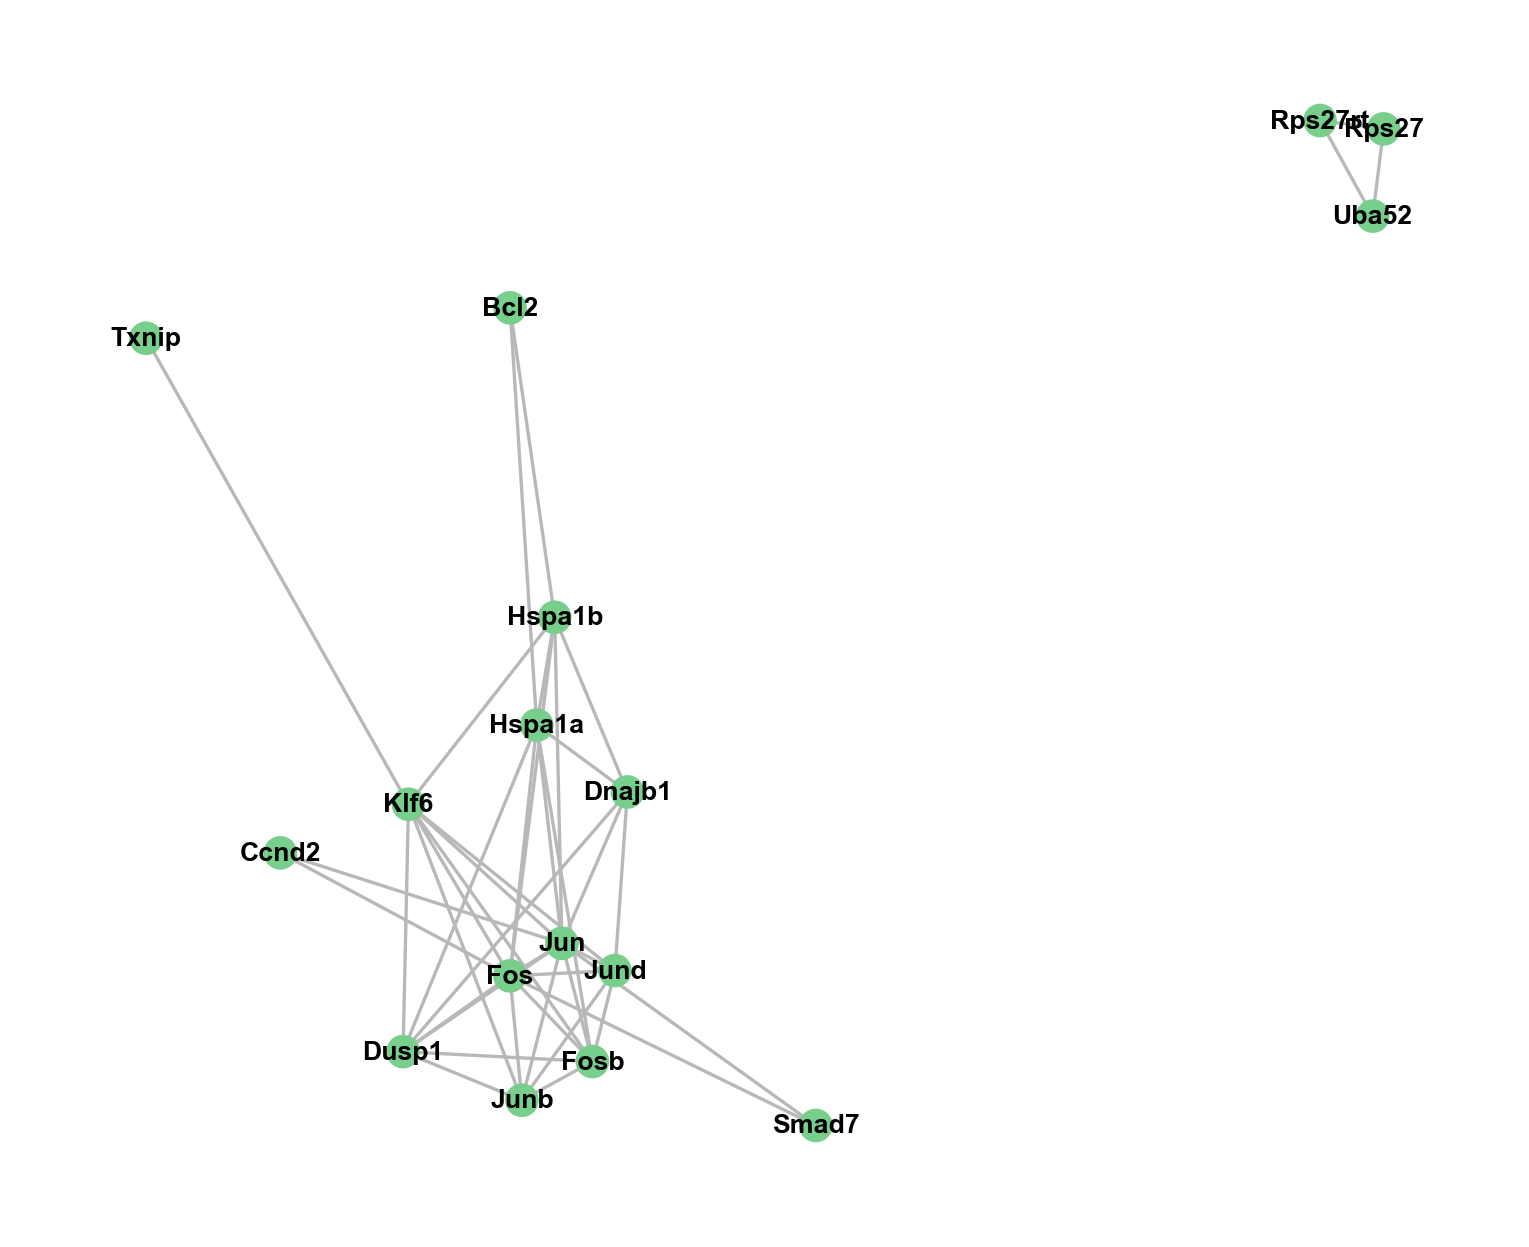

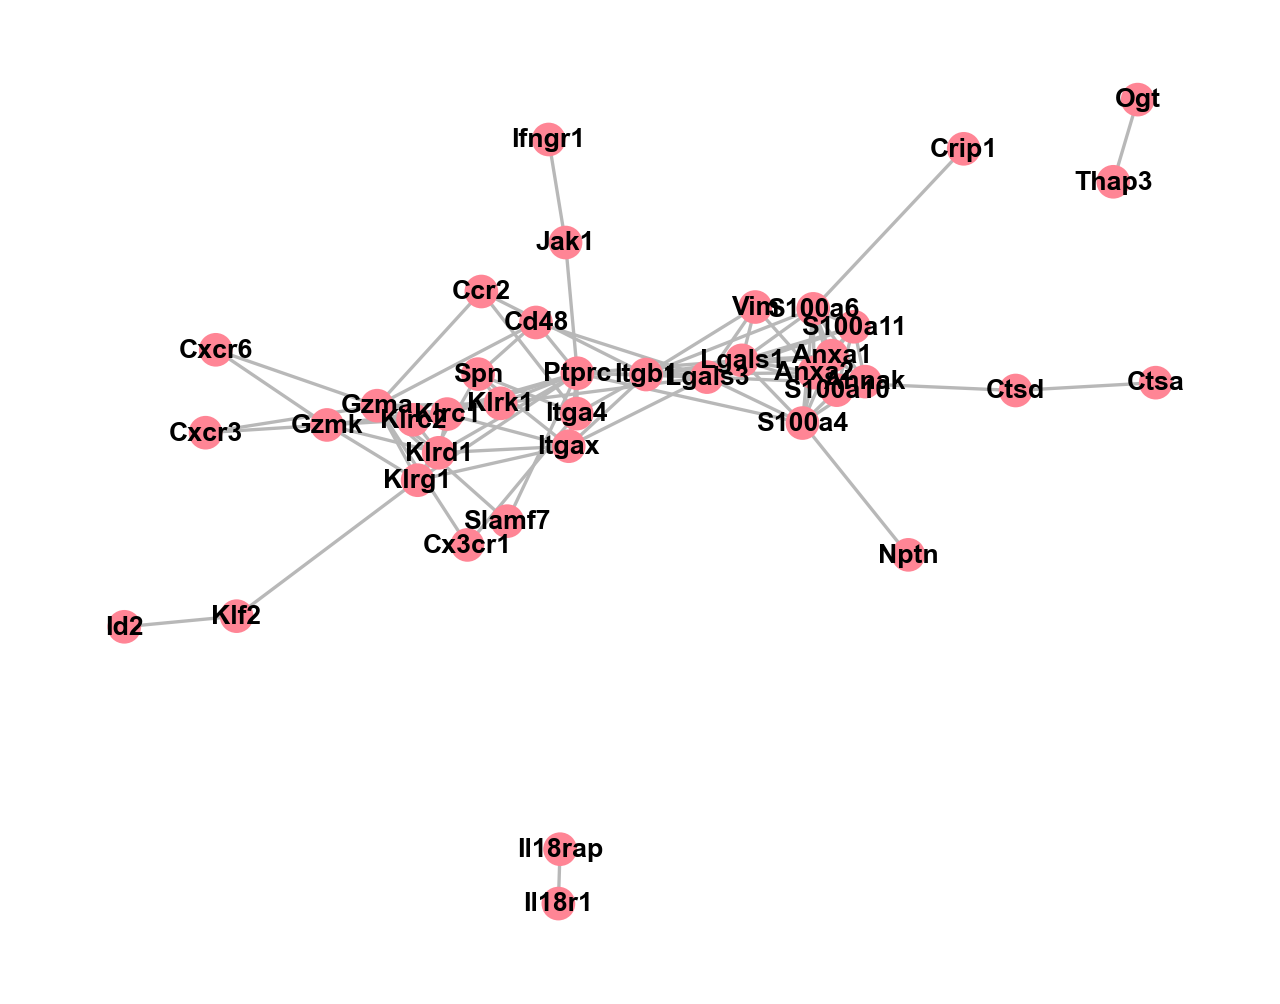

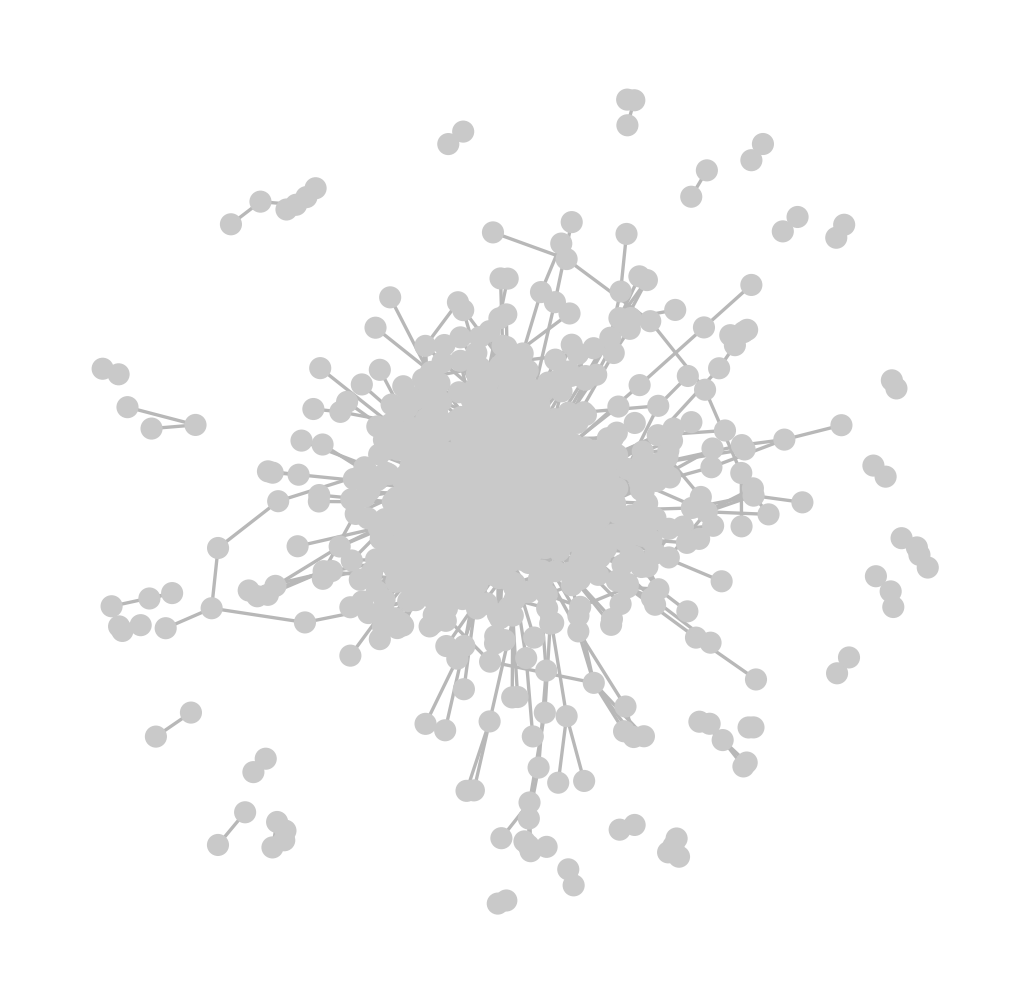

In [4]:
#plot DELVE modules
string_directory = os.path.join('../figures', 'CD8', 'STRING_runner')
module_id = 'dynamic 0'
delve_benchmark.pl.plot_string_G(modules = modules, colors_dict = {'static': '#C9C9C9', 'dynamic 0': '#B46CDA', 'dynamic 1': '#78CE8B', 'dynamic 2': '#FF8595', 'dynamic 3': '#1885F2', 'dynamic 4': '#D78F09', 'dynamic 5': '#665263'}, 
                                module_id = module_id, figsize = (10,10), node_size = 200, font_size = '12', with_labels = True, save_directory = string_directory, filename_save = module_id.replace(' ', '_'))

module_id = 'dynamic 1'
delve_benchmark.pl.plot_string_G(modules = modules, colors_dict = {'static': '#C9C9C9', 'dynamic 0': '#B46CDA', 'dynamic 1': '#78CE8B', 'dynamic 2': '#FF8595', 'dynamic 3': '#1885F2', 'dynamic 4': '#D78F09', 'dynamic 5': '#665263'}, 
                                module_id = module_id, figsize = (12,10), node_size = 200, font_size = '12', with_labels = True, save_directory = string_directory, filename_save = module_id.replace(' ', '_'))

module_id = 'dynamic 2'
delve_benchmark.pl.plot_string_G(modules = modules, colors_dict = {'static': '#C9C9C9', 'dynamic 0': '#B46CDA', 'dynamic 1': '#78CE8B', 'dynamic 2': '#FF8595', 'dynamic 3': '#1885F2', 'dynamic 4': '#D78F09', 'dynamic 5': '#665263'}, 
                                module_id = module_id, figsize = (10,8), node_size = 200, font_size = '12', with_labels = True, save_directory = string_directory, filename_save = module_id.replace(' ', '_'))

module_id = 'static'
delve_benchmark.pl.plot_string_G(modules = modules, colors_dict = {'static': '#C9C9C9', 'dynamic 0': '#B46CDA', 'dynamic 1': '#78CE8B', 'dynamic 2': '#FF8595', 'dynamic 3': '#1885F2', 'dynamic 4': '#D78F09', 'dynamic 5': '#665263'}, 
                                module_id = module_id, figsize = (8,8), node_size = 80, font_size = '12', with_labels = False, save_directory = string_directory, filename_save = module_id)

#### Perform a permutation test to assess the significance of experimentally-derived edges within DELVE modules as compared to random feature-cluster assignment


dynamic 0
dynamic 1
dynamic 2
static


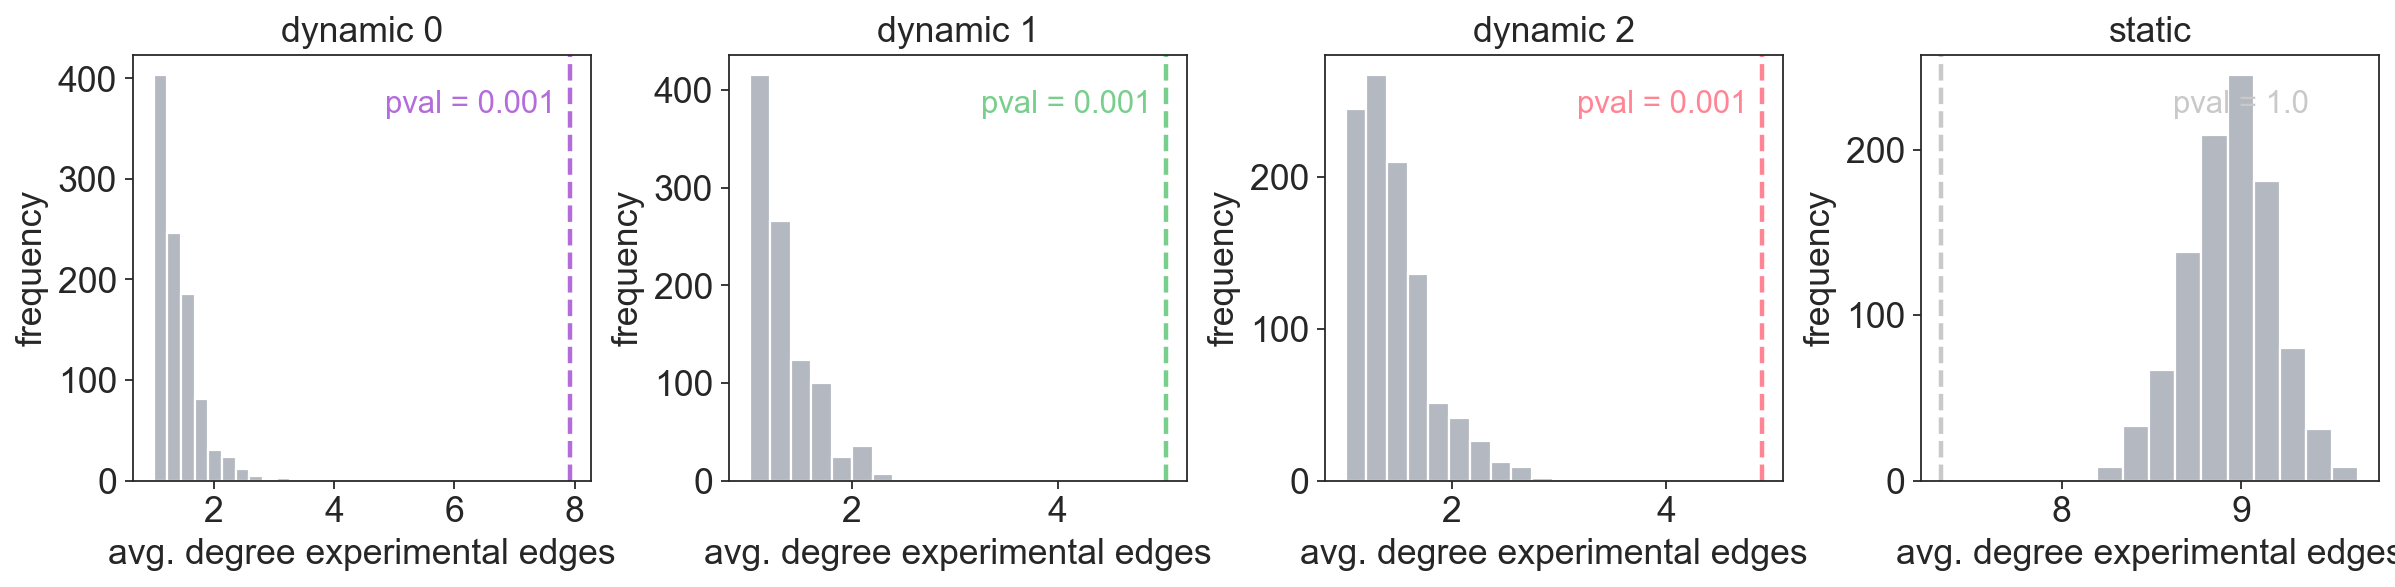

In [5]:
### of note: this takes a while to run
obs_df, rand_df = delve_benchmark.tl.permute_string(modules = modules, niterations= 1000, colors = ['#B46CDA', '#78CE8B', '#FF8595', '#C9C9C9'], species = '10090', save_directory = string_directory)

### Compare trajectory inference performance: DELVE, HVG, Hotspot, Laplacian score

#### Perform feature selection using the alternative methods

In [6]:
## HVG
fs = delve_benchmark.tl.fs(adata = adata, fs_method = delve_benchmark.tl.hvg, fs_method_params = {'n_top_genes': n_selected, 'log': False}) #data already log transformed
hvg_genes = fs.select()
hvg_genes = hvg_genes.index

## Hotspot
fs = delve_benchmark.tl.fs(adata = adata, fs_method = delve_benchmark.tl.hotspot_fs, fs_method_params = {'n_pcs': n_pcs, 'k': k, 'model': 'normal'})
hotspot_genes = fs.select()
hotspot_genes = hotspot_genes.index[:n_selected]

## Laplacian score
fs = delve_benchmark.tl.fs(adata = adata, fs_method = delve_benchmark.tl.laplacian_score_fs, fs_method_params = {'n_pcs': n_pcs, 'k': k})
ls_genes = fs.select()
ls_genes = ls_genes.index[:n_selected]

100%|██████████| 2000/2000 [00:02<00:00, 849.13it/s]


#### Perform trajectory inference on selected feature set and regression analysis to identify significant dynamically expressed genes

INFO:root:estimating diffusion pseudotime using DELVE genes
INFO:root:root cell 2273


         Falling back to preprocessing with `sc.pp.pca` and default params.


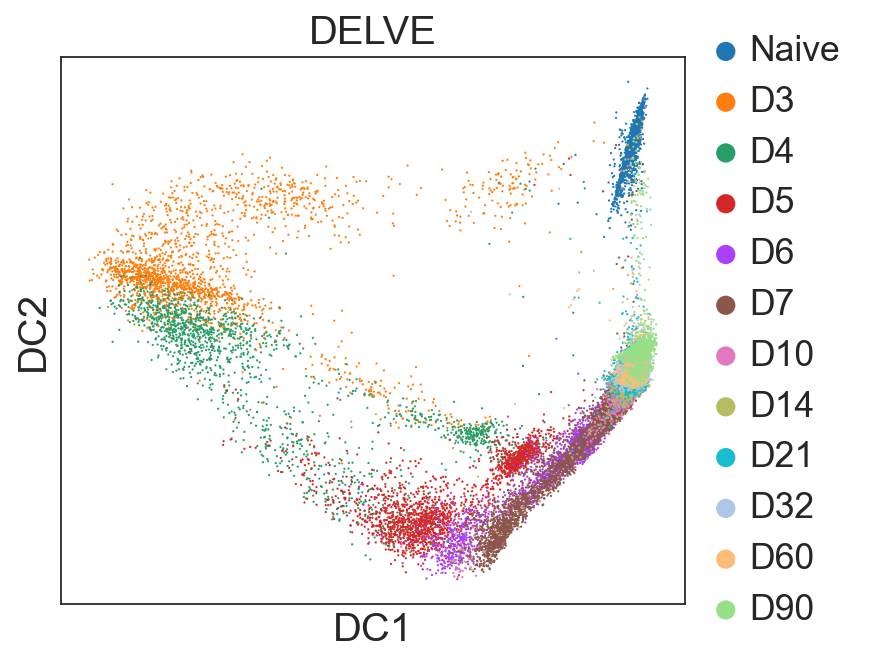

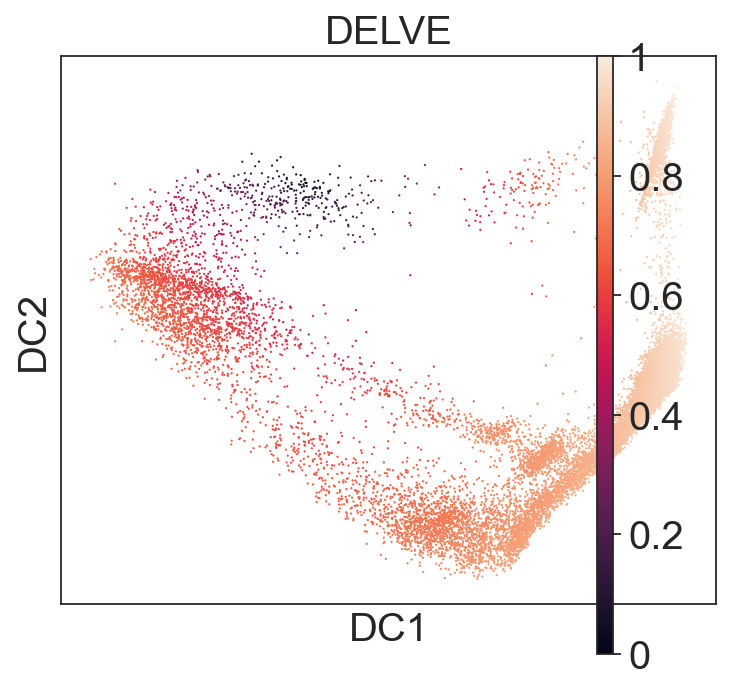

INFO:root:root cell 3409


         Falling back to preprocessing with `sc.pp.pca` and default params.


INFO:root:root cell 3550


         Falling back to preprocessing with `sc.pp.pca` and default params.


INFO:root:root cell 2923


         Falling back to preprocessing with `sc.pp.pca` and default params.


INFO:root:root cell 3664


         Falling back to preprocessing with `sc.pp.pca` and default params.


INFO:root:root cell 3771


         Falling back to preprocessing with `sc.pp.pca` and default params.


INFO:root:root cell 3033


         Falling back to preprocessing with `sc.pp.pca` and default params.


INFO:root:root cell 2291


         Falling back to preprocessing with `sc.pp.pca` and default params.


INFO:root:root cell 2846


         Falling back to preprocessing with `sc.pp.pca` and default params.


INFO:root:root cell 2899


         Falling back to preprocessing with `sc.pp.pca` and default params.


INFO:root:estimating diffusion pseudotime using HVG genes
INFO:root:root cell 2273


         Falling back to preprocessing with `sc.pp.pca` and default params.


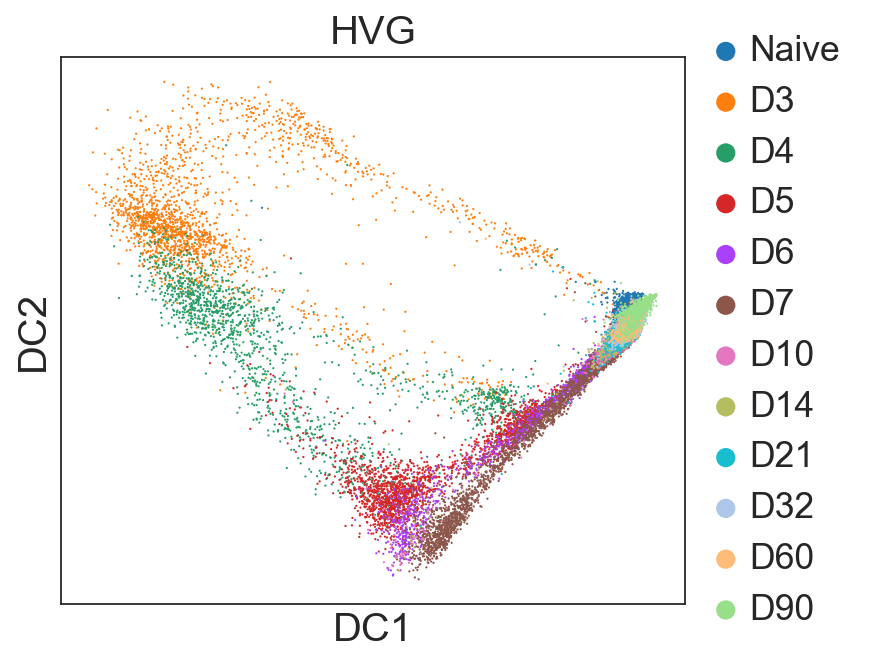

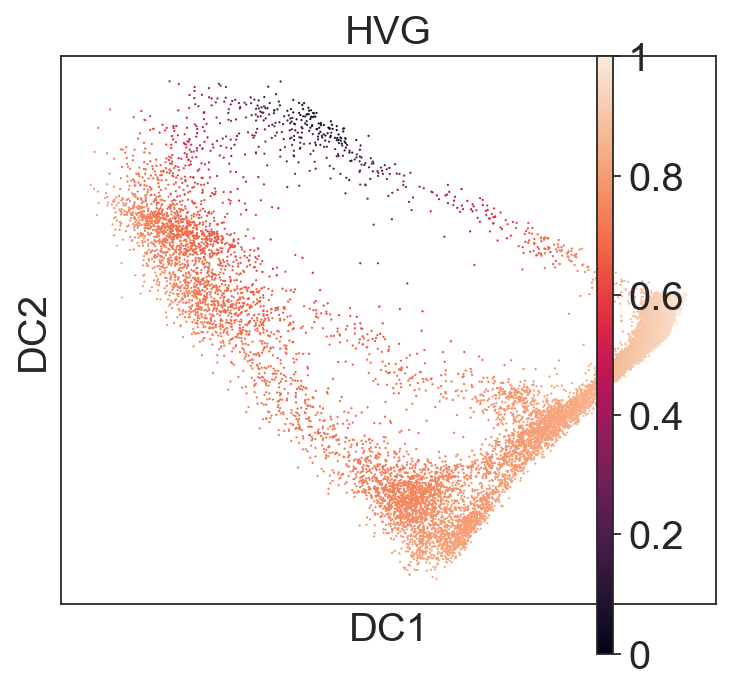

INFO:root:root cell 3409


         Falling back to preprocessing with `sc.pp.pca` and default params.


INFO:root:root cell 3550


         Falling back to preprocessing with `sc.pp.pca` and default params.


INFO:root:root cell 2923


         Falling back to preprocessing with `sc.pp.pca` and default params.


INFO:root:root cell 3664


         Falling back to preprocessing with `sc.pp.pca` and default params.


INFO:root:root cell 3771


         Falling back to preprocessing with `sc.pp.pca` and default params.


INFO:root:root cell 3033


         Falling back to preprocessing with `sc.pp.pca` and default params.


INFO:root:root cell 2291


         Falling back to preprocessing with `sc.pp.pca` and default params.


INFO:root:root cell 2846


         Falling back to preprocessing with `sc.pp.pca` and default params.


INFO:root:root cell 2899


         Falling back to preprocessing with `sc.pp.pca` and default params.


INFO:root:estimating diffusion pseudotime using Hotspot genes
INFO:root:root cell 2273


         Falling back to preprocessing with `sc.pp.pca` and default params.


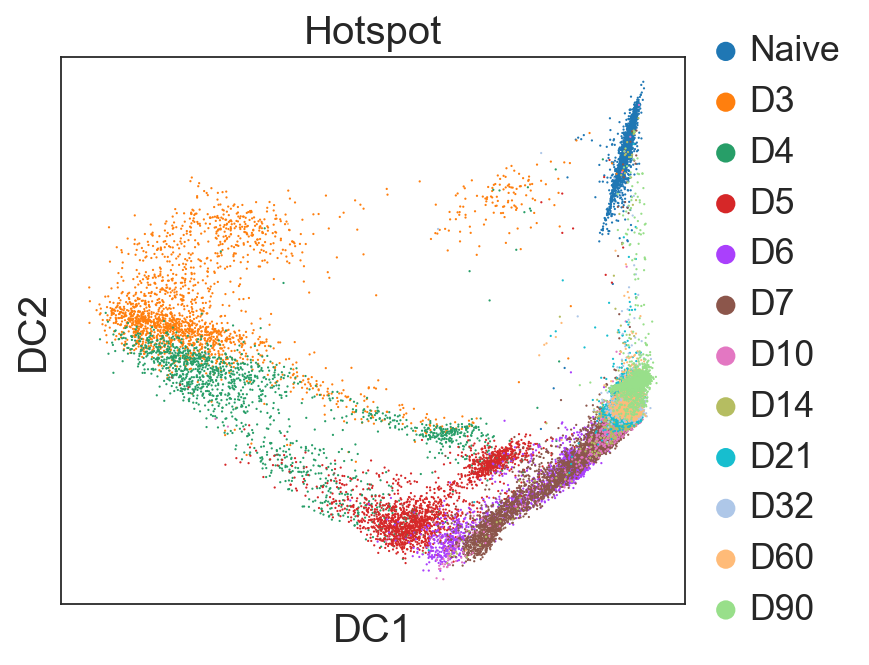

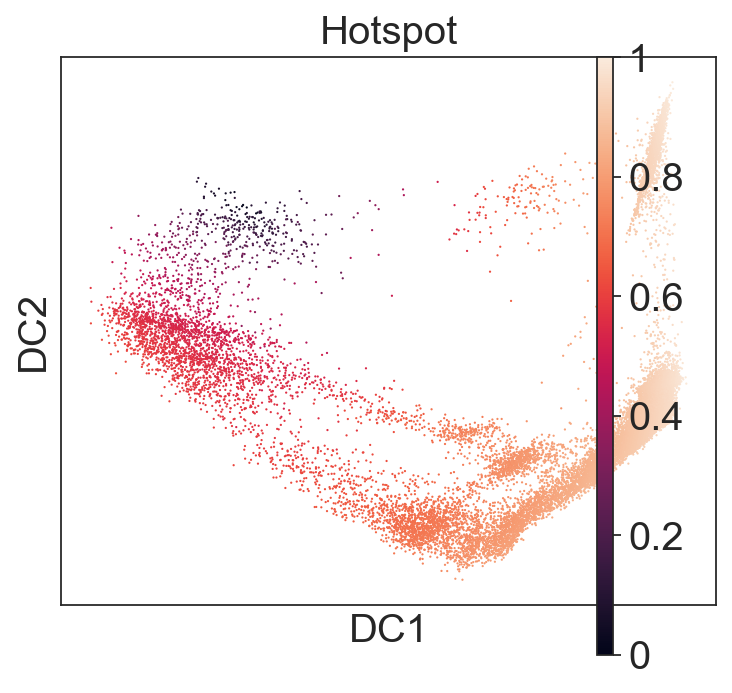

INFO:root:root cell 3409


         Falling back to preprocessing with `sc.pp.pca` and default params.


INFO:root:root cell 3550


         Falling back to preprocessing with `sc.pp.pca` and default params.


INFO:root:root cell 2923


         Falling back to preprocessing with `sc.pp.pca` and default params.


INFO:root:root cell 3664


         Falling back to preprocessing with `sc.pp.pca` and default params.


INFO:root:root cell 3771


         Falling back to preprocessing with `sc.pp.pca` and default params.


INFO:root:root cell 3033


         Falling back to preprocessing with `sc.pp.pca` and default params.


INFO:root:root cell 2291


         Falling back to preprocessing with `sc.pp.pca` and default params.


INFO:root:root cell 2846


         Falling back to preprocessing with `sc.pp.pca` and default params.


INFO:root:root cell 2899


         Falling back to preprocessing with `sc.pp.pca` and default params.


INFO:root:estimating diffusion pseudotime using LS genes
INFO:root:root cell 2273


         Falling back to preprocessing with `sc.pp.pca` and default params.


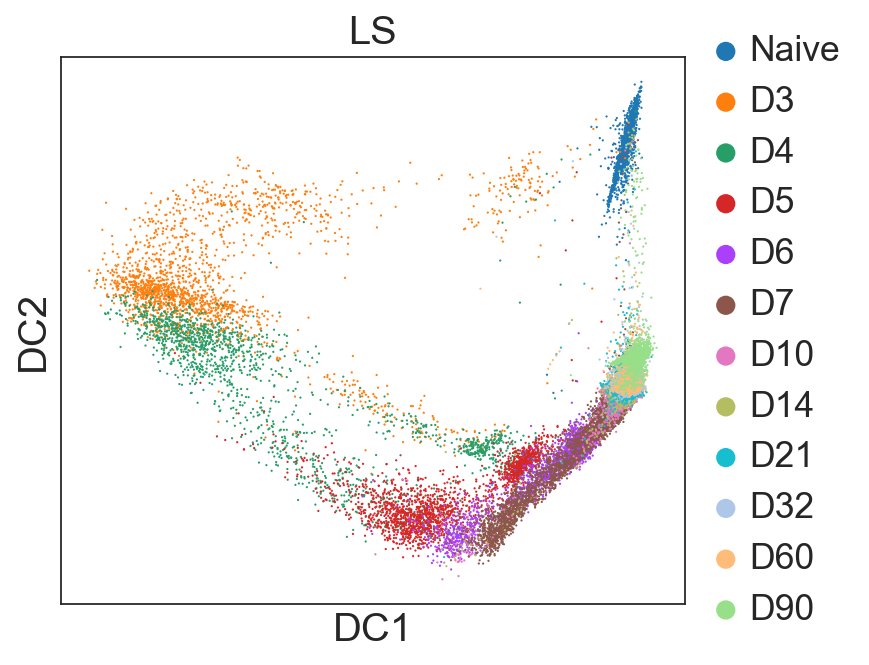

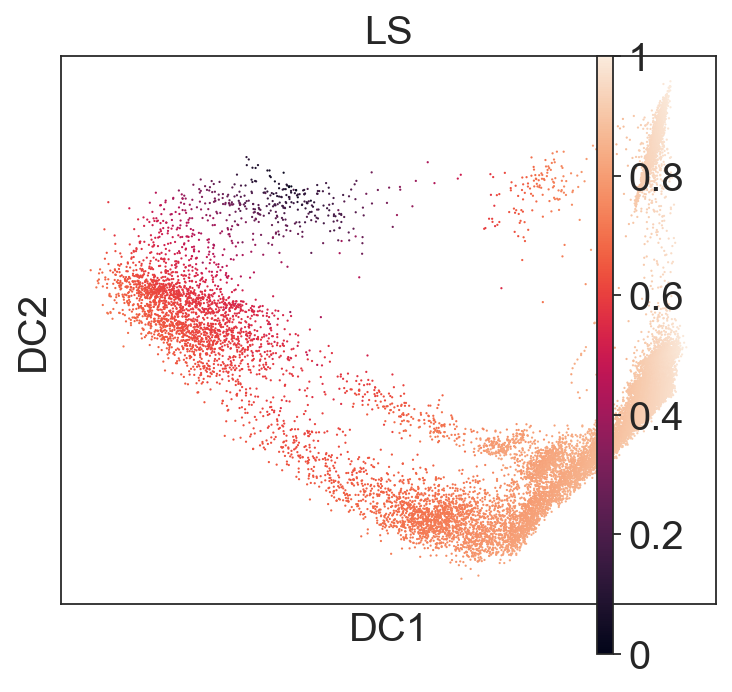

INFO:root:root cell 3409


         Falling back to preprocessing with `sc.pp.pca` and default params.


INFO:root:root cell 3550


         Falling back to preprocessing with `sc.pp.pca` and default params.


INFO:root:root cell 2923


         Falling back to preprocessing with `sc.pp.pca` and default params.


INFO:root:root cell 3664


         Falling back to preprocessing with `sc.pp.pca` and default params.


INFO:root:root cell 3771


         Falling back to preprocessing with `sc.pp.pca` and default params.


INFO:root:root cell 3033


         Falling back to preprocessing with `sc.pp.pca` and default params.


INFO:root:root cell 2291


         Falling back to preprocessing with `sc.pp.pca` and default params.


INFO:root:root cell 2846


         Falling back to preprocessing with `sc.pp.pca` and default params.


INFO:root:root cell 2899


         Falling back to preprocessing with `sc.pp.pca` and default params.


In [7]:
##access selected features
gene_lists = [list(delve_genes),
              list(hvg_genes),
              list(hotspot_genes),
              list(ls_genes)]

titles = ['DELVE', 'HVG', 'Hotspot', 'LS']

root_cells = [2273, 3409, 3550, 2923, 3664, 3771, 3033, 2291, 2846, 2899] #np.random.choice(np.where(np.isin(adata.obs['day'], 'D3'))[0], 10)
de_gene_lists_all = []
for i in range(0, len(gene_lists)):
    de_gene_lists = pd.DataFrame()
    logging.info(f'estimating diffusion pseudotime using {titles[i]} genes')
    for j in range(0, len(root_cells)):     
        #subset adata according to selected features
        adata_run = adata.copy()
        adata_run = adata_run[:, np.isin(adata_run.var_names, gene_lists[i])].copy()

        #obtain root cell for trajectory inference        
        root_cell = root_cells[j]
        logging.info(f'root cell {root_cell}')

        #perform trajectory inference and regression analysis to find significant dynamically expressed genes
        adata_run, de_df = delve_benchmark.tl.compute_de(adata = adata_run, de_method = delve_benchmark.tl.perform_dpt, de_params = {'k': 10, 'n_pcs': 50, 'n_dcs': 20, 'root': root_cell})
        
        #plot trajectory
        if j == 0: #save the first for visual representation
            fig, ax = plt.subplots(figsize = (5, 4.5),  gridspec_kw={'hspace': 0.45, 'wspace': 0.4})
            sc.pl.scatter(adata_run, basis = 'diffmap', title = titles[i], color = 'day', ax = ax, legend_fontsize=16)
            fig, ax = plt.subplots(figsize = (5.25,4.5))
            sc.pl.scatter(adata_run, basis = 'diffmap', title = titles[i], color = 'dpt_pseudotime', ax = ax, legend_fontsize=16)

        de_df.columns = [root_cell]
        de_gene_lists = pd.concat([de_gene_lists, de_df], axis = 1)
    de_gene_lists_all.append(de_gene_lists)

#### Perform gene set enrichment analysis using [Enrichr](https://gseapy.readthedocs.io/en/latest/introduction.html)

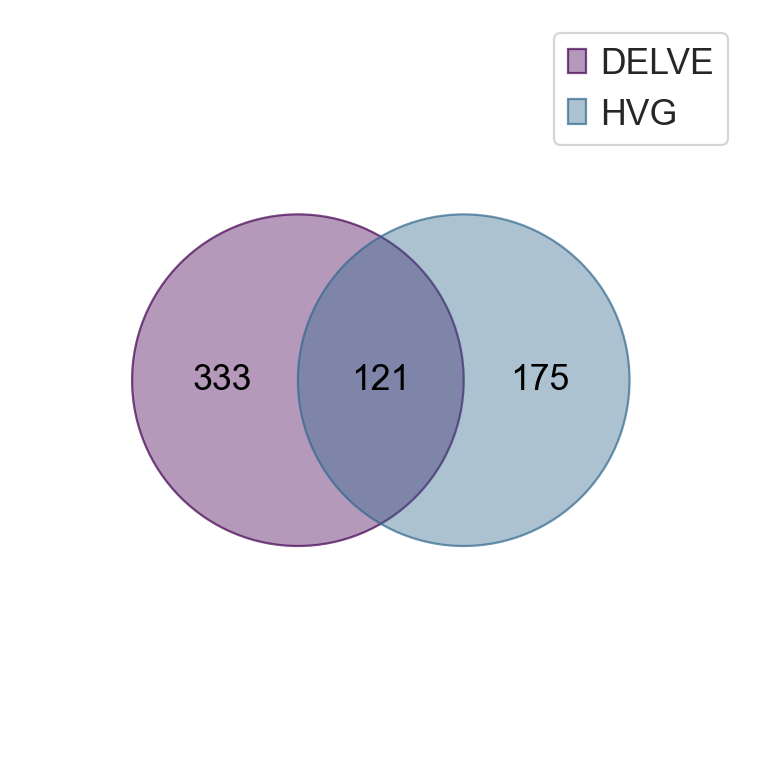

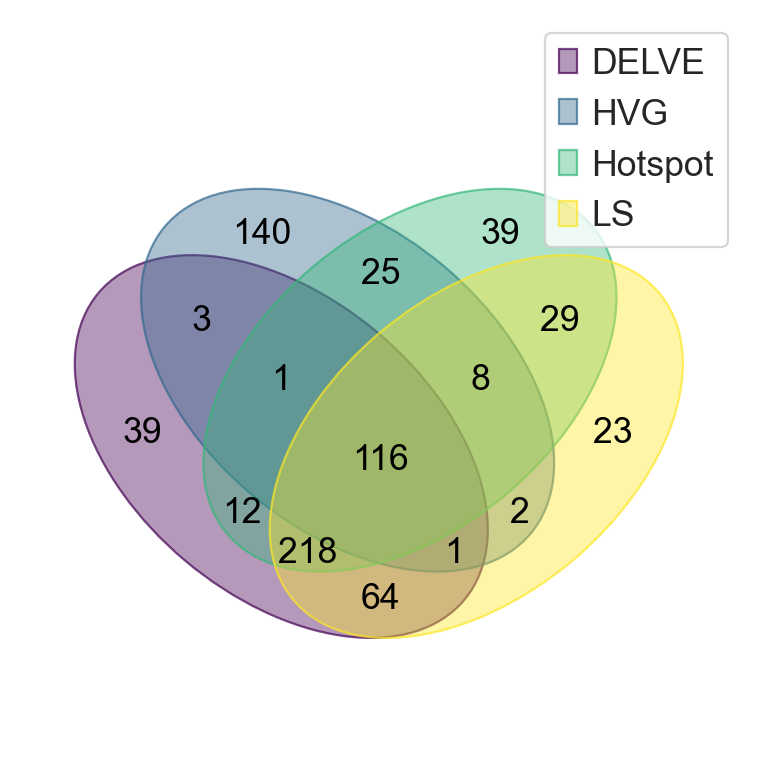

In [8]:
## plot overlapping genes
colors = delve_benchmark.pl.generate_colors(cmap="viridis", n_colors = 4, alpha = 0.4)

for root_cell in [root_cells[0]]: #only showing the first for visual representation
    delve_genes_pst = de_gene_lists_all[0].loc[:, root_cell][~de_gene_lists_all[0].loc[:, root_cell].isna()].sort_values(ascending = True).index
    hvg_genes_pst = de_gene_lists_all[1].loc[:, root_cell][~de_gene_lists_all[1].loc[:, root_cell].isna()].sort_values(ascending = True).index
    hotspot_genes_pst = de_gene_lists_all[2].loc[:, root_cell][~de_gene_lists_all[2].loc[:, root_cell].isna()].sort_values(ascending = True).index
    laplacian_score_genes_pst = de_gene_lists_all[3].loc[:, root_cell][~de_gene_lists_all[3].loc[:, root_cell].isna()].sort_values(ascending = True).index

    # DELVE vs. HVG
    fig, axes = plt.subplots(1, 1, figsize = (6,6), gridspec_kw={'hspace': 0.4, 'wspace': 0.3, 'bottom':0.15})
    feature_list = {"DELVE": set(delve_genes_pst),
                "HVG": set(hvg_genes_pst)}
    g = venn(feature_list, fontsize=16, cmap = colors[:2], ax = axes, legend_loc="upper right")
    plt.show()

    # DELVE vs. all
    fig, axes = plt.subplots(1, 1, figsize = (6,6), gridspec_kw={'hspace': 0.4, 'wspace': 0.3, 'bottom':0.15})
    feature_list = {"DELVE": set(delve_genes_pst),
                    "HVG": set(hvg_genes_pst),
                    "Hotspot": set(hotspot_genes_pst),
                    "LS": set(laplacian_score_genes_pst)}
    g = venn(feature_list, fontsize=16, cmap = colors, ax = axes, legend_loc="upper right")
    plt.show()

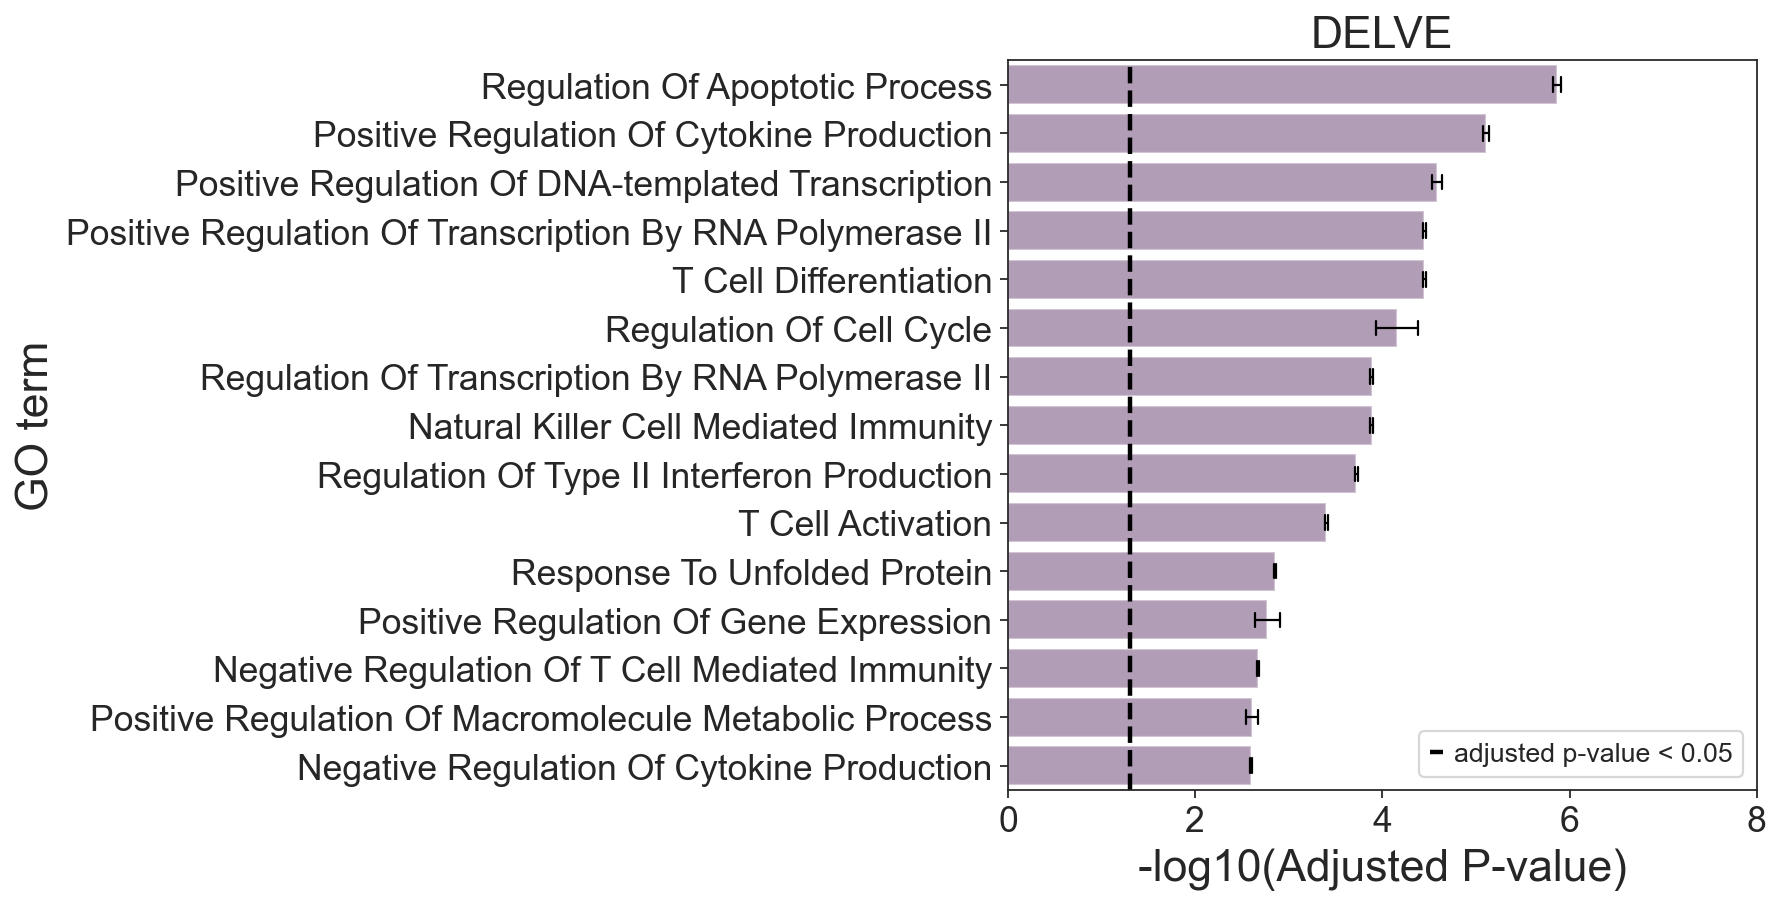

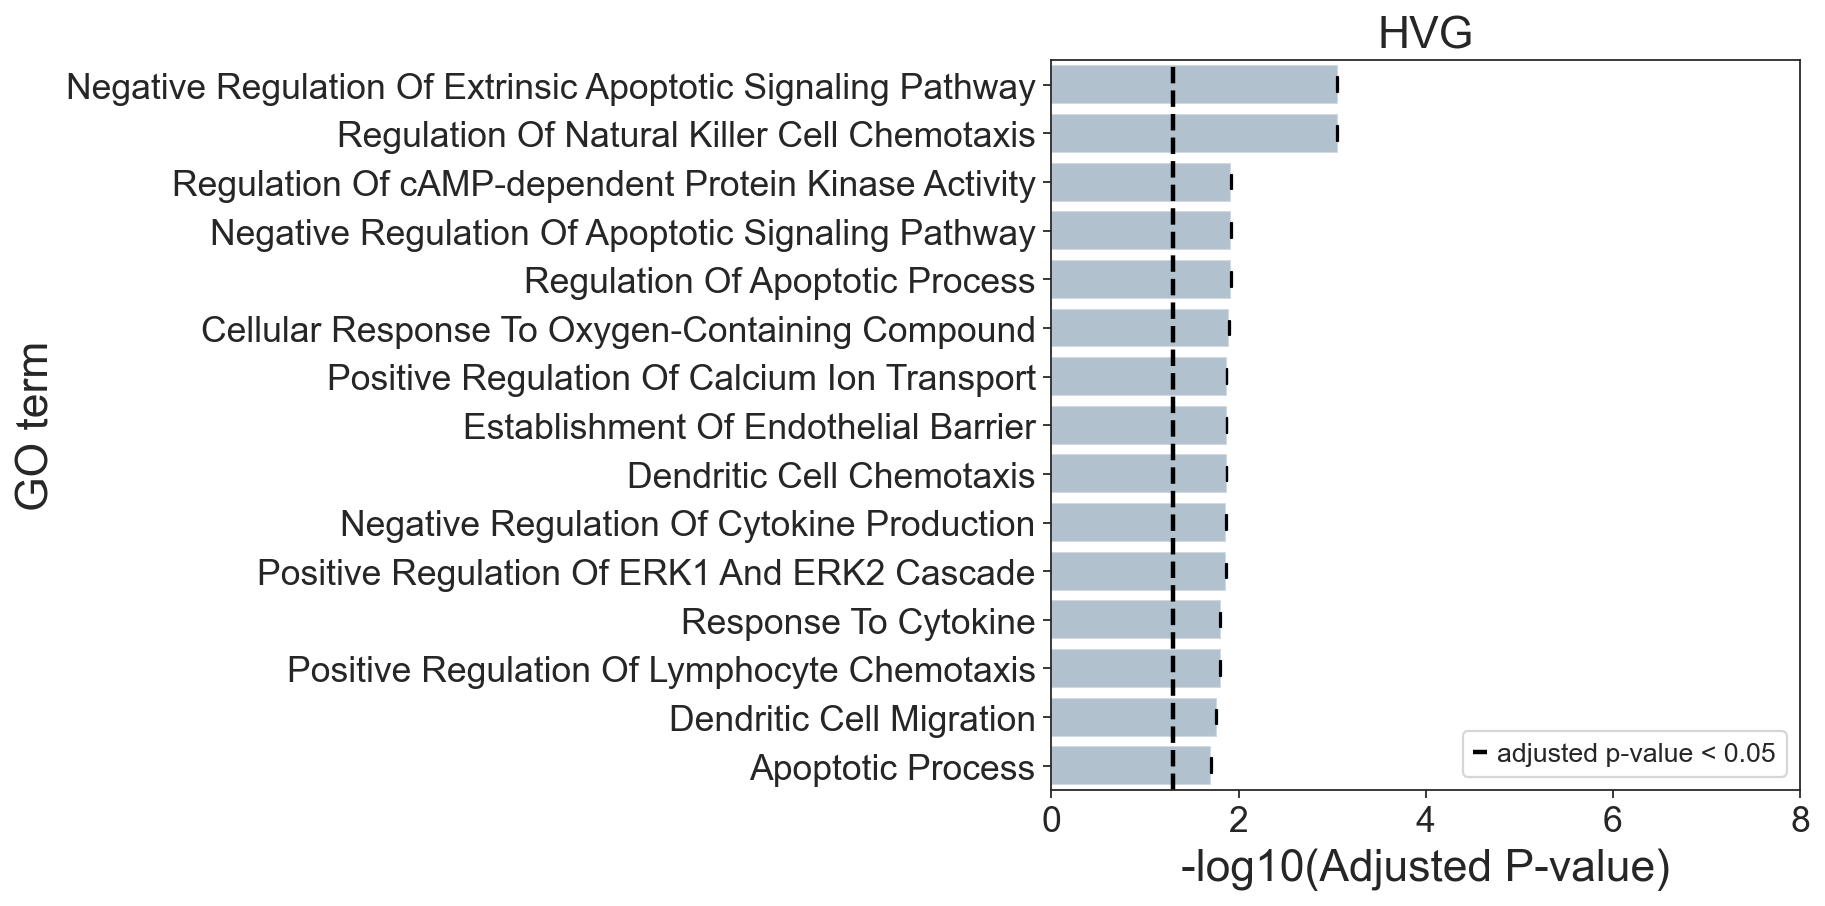

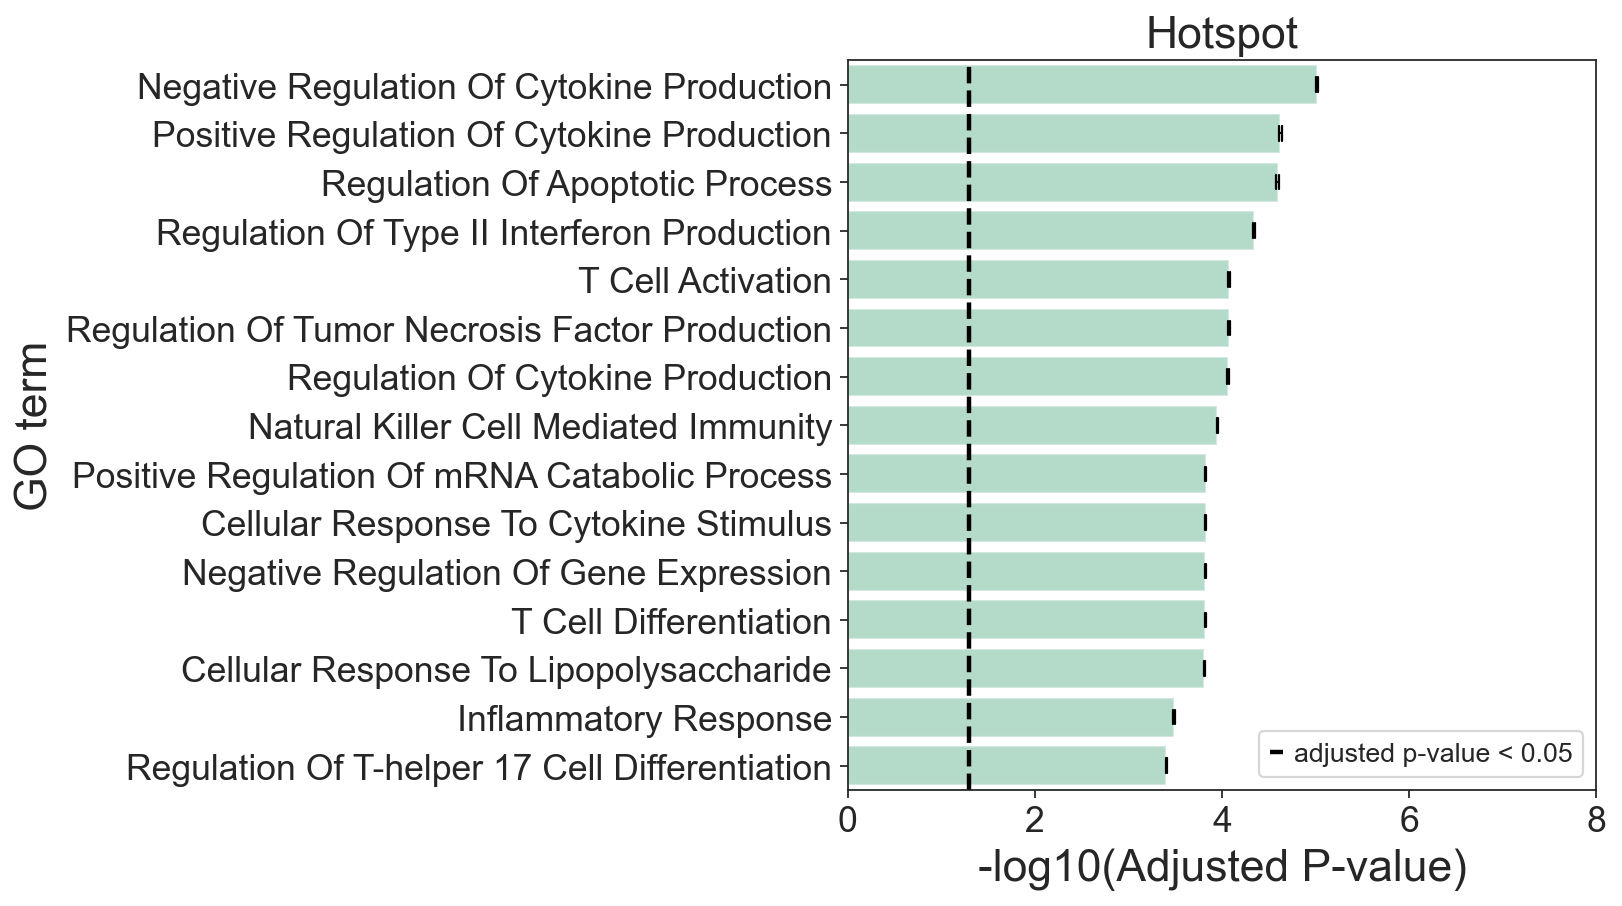

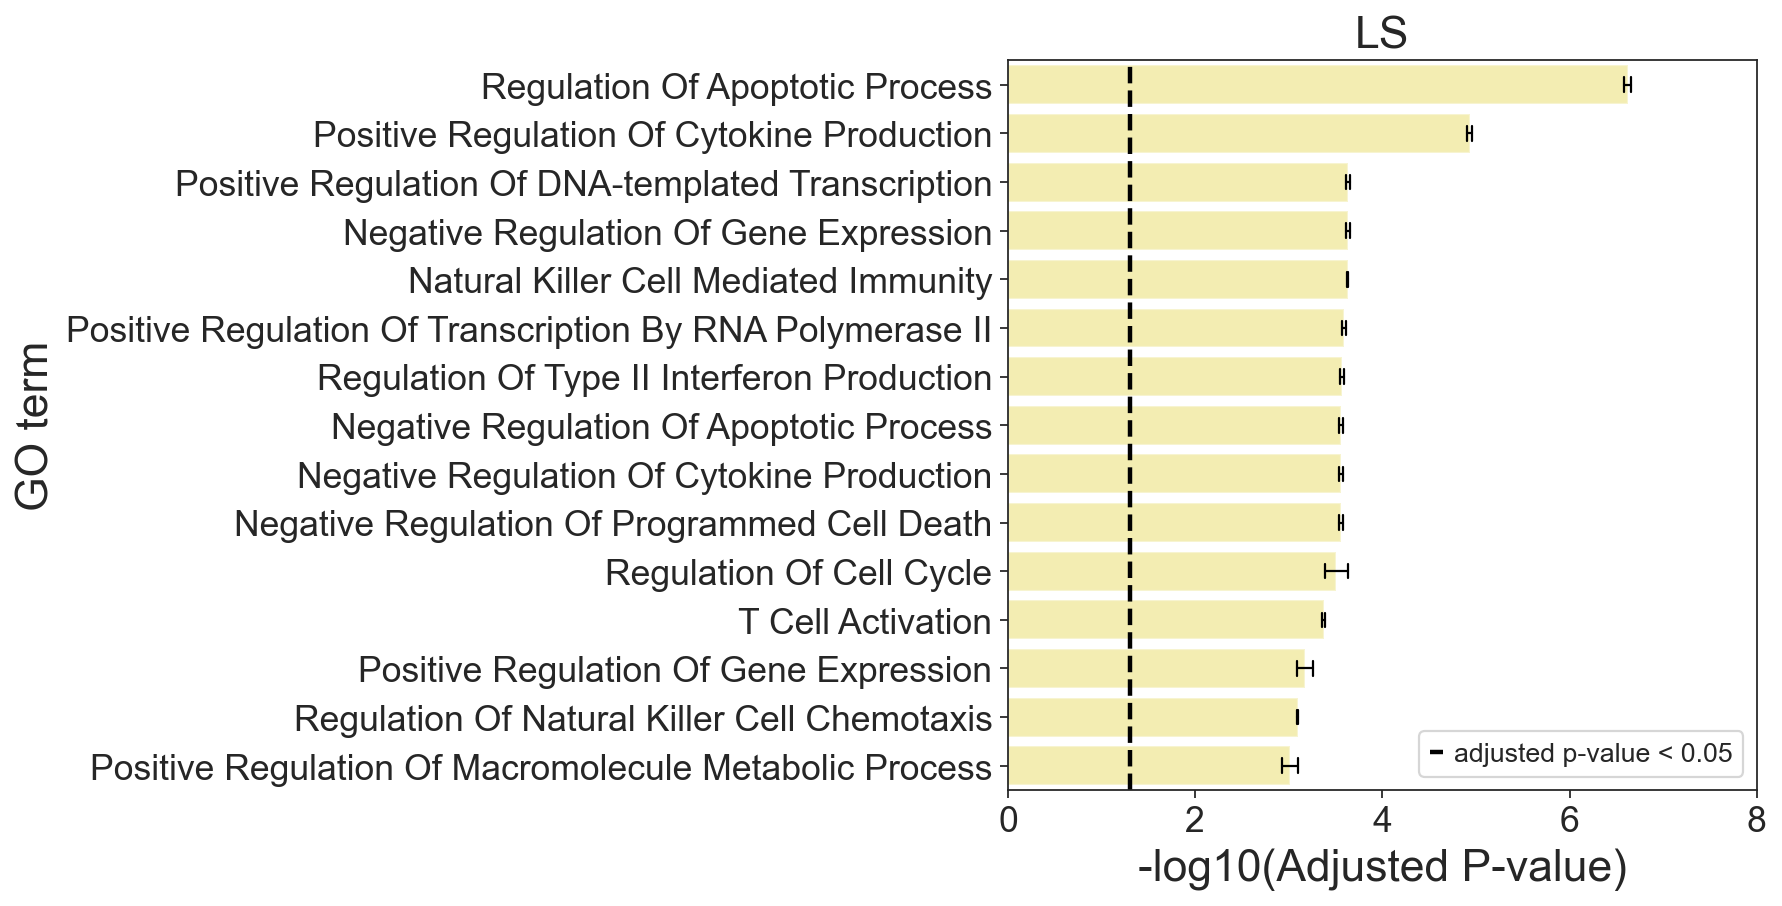

In [9]:
## plot gene ontology scores
gene_sets = ['GO_Biological_Process_2023']
organism = 'mouse'
xlim = [0, 8]

## DELVE
delve_benchmark.pl.plot_GO(de_gene_lists_all[0], gene_sets = gene_sets, organism = organism, xlim = xlim, color = colors[0], sig_cutoff= 0.05, save_directory = None, filename_save = titles[0])
## HVG
delve_benchmark.pl.plot_GO(de_gene_lists_all[1], gene_sets = gene_sets, organism = organism, xlim = xlim, color = colors[1], sig_cutoff= 0.05, save_directory = None, filename_save = titles[1])
## Hotspot
delve_benchmark.pl.plot_GO(de_gene_lists_all[2], gene_sets = gene_sets, organism = organism, xlim = xlim, color = colors[2], sig_cutoff= 0.05, save_directory = None, filename_save = titles[2])
## LS
delve_benchmark.pl.plot_GO(de_gene_lists_all[3], gene_sets = gene_sets, organism = organism, xlim = xlim, color = colors[3], sig_cutoff= 0.05, save_directory = None, filename_save = titles[3])